In [12]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from tqdm import tqdm

In [34]:
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 66
EPOCHS = 40
LR = 0.01
device = "cuda" if torch.cuda.is_available() else "cpu"
print('[INFO] Running on ' + device)

[INFO] Running on cpu


In [15]:
train_dataset = datasets.ImageFolder('./dataset/covid19/train',
    transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
)
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

In [32]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def add_noise(img, noise_factor=0.5):
    noisy_img = img + noise_factor * torch.randn_like(img)
    noisy_img = torch.clamp(noisy_img, 0., 1.)
    return noisy_img
def add_complex_noise(img):
    gaussian_noise = img + 0.5 * torch.randn_like(img)
    salt_pepper_noise = img.clone()
    salt_pepper_noise[torch.rand_like(img) > 0.95] = 1.0
    salt_pepper_noise[torch.rand_like(img) < 0.05] = 0.0
    noisy_img = gaussian_noise * 0.7 + salt_pepper_noise * 0.3
    return torch.clamp(noisy_img, 0., 1.)

### 边缘看中损失函数

In [68]:
import torch
import torch.nn.functional as F

# 定义 Sobel 算子用于计算图像梯度
sobel_x = torch.tensor(
    [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]],
    dtype=torch.float32  # 设置为 float32 类型
).unsqueeze(0).unsqueeze(0)

sobel_y = torch.tensor(
    [[-1, -2, -1], [0, 0, 0], [1, 2, 1]],
    dtype=torch.float32  # 设置为 float32 类型
).unsqueeze(0).unsqueeze(0)

def edge_loss(original, reconstructed, device):
    # 将 Sobel 算子移动到 GPU 或 CPU
    sobel_x_device = sobel_x.to(device)
    sobel_y_device = sobel_y.to(device)

    # 计算原始图像和重建图像的梯度
    original_edges_x = F.conv2d(original, sobel_x_device, padding=1)
    original_edges_y = F.conv2d(original, sobel_y_device, padding=1)
    reconstructed_edges_x = F.conv2d(reconstructed, sobel_x_device, padding=1)
    reconstructed_edges_y = F.conv2d(reconstructed, sobel_y_device, padding=1)

    # 计算梯度差异的 MSE
    edge_diff_x = F.mse_loss(reconstructed_edges_x, original_edges_x)
    edge_diff_y = F.mse_loss(reconstructed_edges_y, original_edges_y)
    return edge_diff_x + edge_diff_y

def final_loss(original, reconstructed, device):
    # MSE 损失
    mse_loss = F.mse_loss(reconstructed, original)
    # 边缘损失
    edge_loss_val = edge_loss(original, reconstructed, device)
    # 总损失：MSE + 边缘损失的权重
    return mse_loss + 0.1 * edge_loss_val  # 权重可以调整

In [69]:
autoencoder = Autoencoder().to(device)
# criterion = nn.MSELoss()
# 修改 criterion
criterion = lambda reconstructed, img: final_loss(reconstructed, img, device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)

In [65]:
# 仅使用一个 batch 计算初始损失
with torch.no_grad():
    img, _ = next(iter(train_dataloader))  # 获取一个 batch
    img = img.to(device)
    noisy_img = add_complex_noise(img)
    reconstructed = autoencoder(noisy_img)
    initial_loss = criterion(reconstructed, img).item()

print(f"Initial Loss (one batch): {initial_loss:.4f}")

AttributeError: 'tuple' object has no attribute 'item'

In [ ]:
autoencoder.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for img, label in tqdm(train_dataloader):
        img = img.to(device)
        noisy_img = add_complex_noise(img)
        optimizer.zero_grad()
        reconstructed = autoencoder(noisy_img)
        loss = criterion(reconstructed, img)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} Loss: {total_loss / len(train_dataloader):.4f}")

100%|██████████| 8/8 [00:38<00:00,  4.84s/it]


Epoch 1/40 Loss: 0.1134


100%|██████████| 8/8 [00:39<00:00,  5.00s/it]


Epoch 2/40 Loss: 0.0536


100%|██████████| 8/8 [00:42<00:00,  5.31s/it]


Epoch 3/40 Loss: 0.0230


100%|██████████| 8/8 [00:41<00:00,  5.20s/it]


Epoch 4/40 Loss: 0.0158


100%|██████████| 8/8 [00:42<00:00,  5.34s/it]


Epoch 5/40 Loss: 0.0138


 25%|██▌       | 2/8 [00:10<00:30,  5.11s/it]

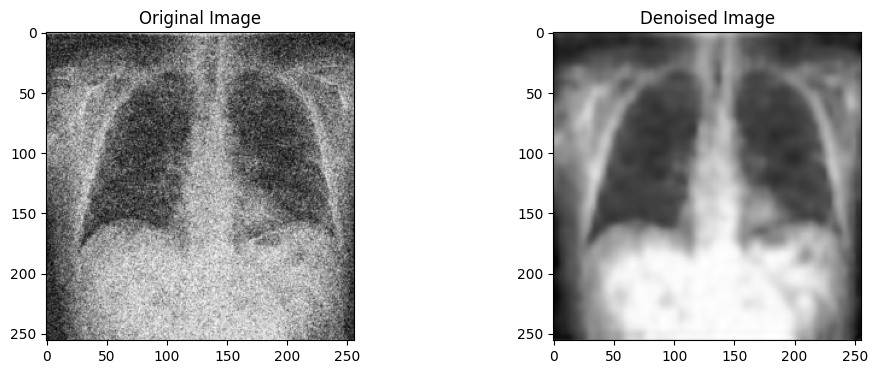

In [44]:
autoencoder.eval()

test_dataset = datasets.ImageFolder('./dataset/covid19/noisy_test',
    transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
)
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

def visualize_denoising(original, denoised):
    """可视化对比原始、带噪和去噪图片"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].imshow(original.cpu().squeeze(), cmap='gray')
    axes[0].set_title("Original Image")
    axes[1].imshow(denoised.cpu().squeeze(), cmap='gray')
    axes[1].set_title("Denoised Image")
    plt.show()

# 去噪过程
with torch.no_grad():  # 不需要计算梯度
    for img, _ in test_dataloader:
        img = img.to(device)
        denoised_img = autoencoder(img)  # 使用训练好的 autoencoder 去噪

        # 可视化一个批次
        visualize_denoising(img[0], denoised_img[0])


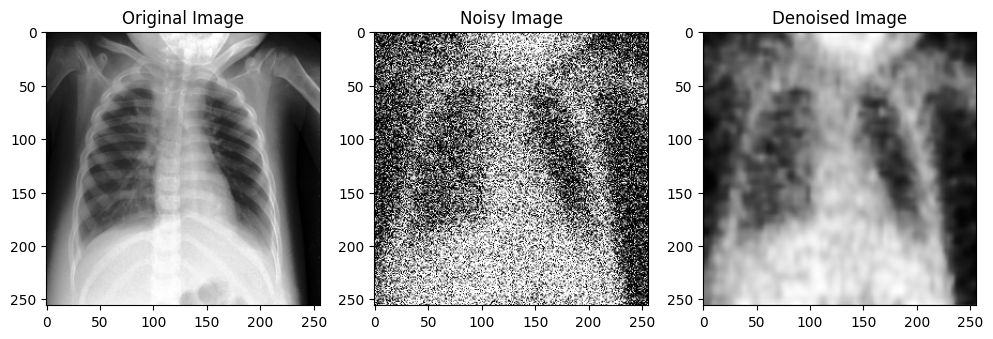

In [46]:
autoencoder.eval()
def visualize_denoising(original, noisy, denoised):
    """可视化对比原始、带噪和去噪图片"""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(original.cpu().squeeze(), cmap='gray')
    axes[0].set_title("Original Image")
    axes[1].imshow(noisy.cpu().squeeze(), cmap='gray')
    axes[1].set_title("Noisy Image")
    axes[2].imshow(denoised.cpu().squeeze(), cmap='gray')
    axes[2].set_title("Denoised Image")
    plt.show()

# 去噪过程
with torch.no_grad():  # 不需要计算梯度
    for img, _ in train_dataloader:
        img = img.to(device)
        noisy_img = add_noise(img)  # 添加高斯噪声
        denoised_img = autoencoder(noisy_img)  # 使用训练好的 autoencoder 去噪

        # 可视化一个批次
        visualize_denoising(img[0], noisy_img[0], denoised_img[0])
        break


In [ ]:
import torch.nn.functional as F

def compute_metrics(original, denoised):
    mse = F.mse_loss(denoised, original).item()
    psnr = 10 * torch.log10(1 / mse)  # 假设像素值范围为 [0, 1]
    return mse, psnr

# 评估测试集性能
total_mse, total_psnr = 0, 0
num_images = 0

with torch.no_grad():
    for img, _ in test_dataloader:
        img = img.to(device)
        noisy_img = add_noise(img)
        denoised_img = autoencoder(noisy_img)
        
        mse, psnr = compute_metrics(img, denoised_img)
        total_mse += mse * img.size(0)
        total_psnr += psnr * img.size(0)
        num_images += img.size(0)

# 平均 MSE 和 PSNR
avg_mse = total_mse / num_images
avg_psnr = total_psnr / num_images

print(f"Test Set Performance: MSE = {avg_mse:.4f}, PSNR = {avg_psnr:.2f} dB")